<a href="https://colab.research.google.com/github/LanceryH/C-_stabilization_sensor/blob/main/Other/main_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress

df = pd.read_excel("RP_EC9323-2.xlsx")

[ 25  50  75 100 125]


<ipython-input-84-2852ad7eafcd>:33: RuntimeWarning: invalid value encountered in power
  return Mm * (1 - np.exp(-c1 * (Dx * t / h**2)**c2))


Temperature: 25 °C
Coefficient D (m²/s): 6.301790281144407e-11
Maximum mass loss Mm (%): 1.4468037712341661
Power coef: 3.671202438803197
Mult coef: 0.6172162812922247
----------------------------------------
Temperature: 50 °C
Coefficient D (m²/s): 3.0466735047184644e-10
Maximum mass loss Mm (%): 0.6838151887671405
Power coef: 7.393075776452969
Mult coef: 0.8039712475604196
----------------------------------------


<ipython-input-84-2852ad7eafcd>:33: RuntimeWarning: overflow encountered in exp
  return Mm * (1 - np.exp(-c1 * (Dx * t / h**2)**c2))


Temperature: 75 °C
Coefficient D (m²/s): 4.099610681006083e-12
Maximum mass loss Mm (%): 3.6986103927317626
Power coef: 0.9925200941268931
Mult coef: 0.4623631023173983
----------------------------------------
Temperature: 100 °C
Coefficient D (m²/s): 1.2215557154897985e-10
Maximum mass loss Mm (%): 0.7601310585035326
Power coef: 5.049431708390185
Mult coef: 0.7224904976508306
----------------------------------------
Temperature: 125 °C
Coefficient D (m²/s): 1.5944129589935556e-10
Maximum mass loss Mm (%): 0.7367188169085899
Power coef: 7.183591509104661
Mult coef: 0.8909936327479164
----------------------------------------


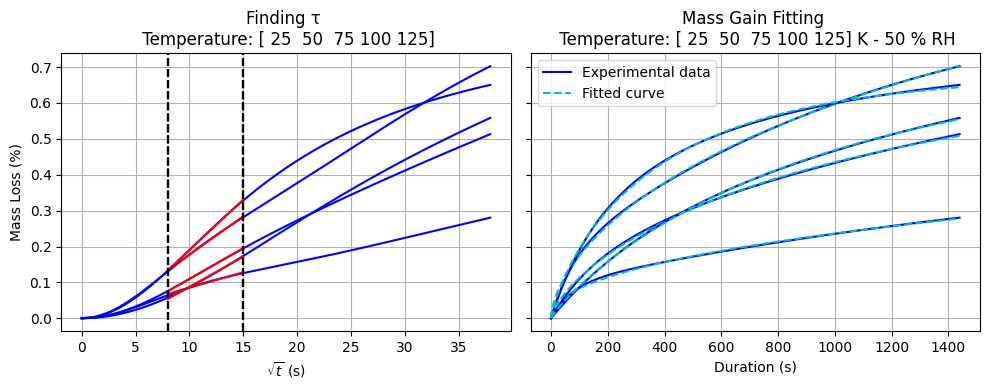

In [84]:
# Split data into temperature steps
temperature_steps = df['Température [°C]'].unique()
print(temperature_steps)
fig, (ax0, ax1) = plt.subplots(figsize=(10, 4), ncols=2, sharey='all')
fitted_curves = []  # List to store the fitted curves
exp_curves = [] # List to store the exp curves
results = []  # List to store the results (D, Mm, Temperature)
D_values = []
T_values = []
h = 0.0012  # thickness in meters
l = 0.010 # Length of the material in meters
n = 0.010 # Width of the material in meters
R = 8.314  # J/(mol·K) Universal gas constant
Coeff_regression = 0.9 # Coefficient de régression à définir pour choix courbe de tendance
sqrt_t1 = 8
sqrt_t2 = 15

for ind_i, temperature in enumerate(temperature_steps):
  # Reset time and mass loss values to start from 0
  t = (df['Time [min]'].values - df['Time [min]'].values[0])[:1440]
  M = (df[f'pred expo{ind_i+1} [%]'].values - df[f'pred expo{ind_i+1} [%]'].values[0])[:1440]
  sqrt_t = np.sqrt(t)

  # Calculate slope and coefficient D
  slope, _ = np.polyfit(sqrt_t[(sqrt_t>sqrt_t1) & (sqrt_t<sqrt_t2)], M[(sqrt_t>sqrt_t1) & (sqrt_t<sqrt_t2)], 1)
  Mm = np.max(M)
  D = slope**2 * (h / (4 * Mm))**2 * np.pi
  Dx = D*(1+h/l+h/n)**-2 #edge effects
  c1, c2 = 7.3, 0.75

  # Define the fitting function
  def mass_loss_model(t, Dx, Mm, c1, c2):
      return Mm * (1 - np.exp(-c1 * (Dx * t / h**2)**c2))

  # Fit the mass loss data with the model
  p0 = [Dx, Mm, c1, c2]  # initial parameter values
  params, pcov = curve_fit(mass_loss_model, t, M, p0=p0,maxfev=2000)

  # Get the fitted curve
  t_fit = np.linspace(0, t[-1], 1000)
  M_fit = mass_loss_model(t_fit, *params)

  # Store the fitted curve
  fitted_curves.append((t_fit, M_fit))

  # Store the experimental curve
  exp_curves.append((t, M))

  # Plot the fitted curve
  ax0.plot(sqrt_t, M, 'b')
  ax0.plot(sqrt_t[(sqrt_t>sqrt_t1) & (sqrt_t<sqrt_t2)],sqrt_t[(sqrt_t>sqrt_t1) & (sqrt_t<sqrt_t2)]*slope+_,'r')
  ax0.axvline(x=sqrt_t1,color="black",linestyle="--",alpha=0.8)
  ax0.axvline(x=sqrt_t2,color="black",linestyle="--",alpha=0.8)
  ax0.set_xlabel(r'$\sqrt{t}$'+' (s)')
  ax0.set_ylabel('Mass Loss (%)')
  ax0.set_title(f'Finding τ \n Temperature: {temperature_steps}')
  ax0.grid(True)

  ax1.plot(t, M, 'b')
  ax1.plot(t_fit, M_fit, 'c--')
  ax1.set_xlabel('Duration (s)')
  ax1.set_title(f'Mass Gain Fitting \n Temperature: {temperature_steps} K - 50 % RH')
  ax1.legend(['Experimental data','Fitted curve'])
  ax1.grid(True)

  fig.tight_layout()


  # Calculate D and Mm from the fitted parameters
  D = params[0]
  Mm = params[1]

  # Calculate ln(D) and corresponding temperature
  ln_D = np.log(D)
  T = temperature
  D_values.append(ln_D)
  T_values.append(1 / T)

  # Append results to the list
  results.append({'Temperature': temperature, 'D': params[0], 'Mm': params[1], "c1": params[2], "c2":  params[3]})

  # Print the coefficient D and Mm
  print(f'Temperature: {temperature} °C')
  print('Coefficient D (m²/s):', params[0])
  print('Maximum mass loss Mm (%):', params[1])
  print('Power coef:',params[2])
  print('Mult coef:',params[3])
  print('----------------------------------------')

plt.show()

[-23.48760226 -21.91180059 -26.2201291  -22.82572571 -22.55934531]


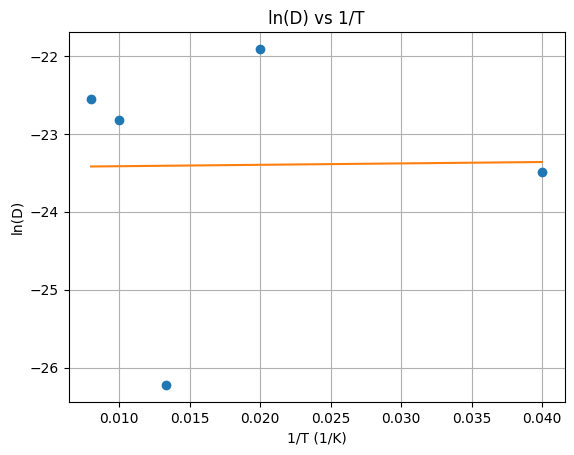

ln(D0): -23.43374845530393
Ea (J/mol): -14.941469397128916
Results Table:
   Temperature             D        Mm        c1        c2
0           25  6.301790e-11  1.446804  3.671202  0.617216
1           50  3.046674e-10  0.683815  7.393076  0.803971
2           75  4.099611e-12  3.698610  0.992520  0.462363
3          100  1.221556e-10  0.760131  5.049432  0.722490
4          125  1.594413e-10  0.736719  7.183592  0.890994


In [85]:
# Convert lists to numpy arrays
D_values = np.array(D_values)
T_values = np.array(T_values)
print(D_values)

# Perform linear regression to find ln(D0) and Ea
slope, intercept, r_value, p_value, std_err = linregress(T_values, D_values)

#Calculate ln(D0) and Ea
ln_D0 = intercept
Ea = -slope * R

#Plot ln(D) vs 1/T
plt.plot(T_values, D_values, 'o')
plt.plot(T_values, intercept - Ea/R * T_values)
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(D)')
plt.title('ln(D) vs 1/T')
plt.grid(True)
plt.show()

#Print ln(D0) and Ea
print('ln(D0):', ln_D0)
print('Ea (J/mol):', Ea)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results table
print('Results Table:')
print(results_df)

0 Temperature    2.500000e+01
D              6.301790e-11
Mm             1.446804e+00
c1             3.671202e+00
c2             6.172163e-01
Name: 0, dtype: float64
1 Temperature    5.000000e+01
D              3.046674e-10
Mm             6.838152e-01
c1             7.393076e+00
c2             8.039712e-01
Name: 1, dtype: float64
2 Temperature    7.500000e+01
D              4.099611e-12
Mm             3.698610e+00
c1             9.925201e-01
c2             4.623631e-01
Name: 2, dtype: float64
3 Temperature    1.000000e+02
D              1.221556e-10
Mm             7.601311e-01
c1             5.049432e+00
c2             7.224905e-01
Name: 3, dtype: float64
4 Temperature    1.250000e+02
D              1.594413e-10
Mm             7.367188e-01
c1             7.183592e+00
c2             8.909936e-01
Name: 4, dtype: float64


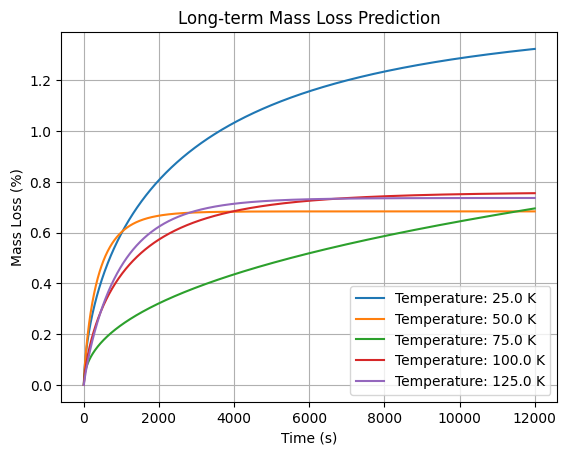

In [86]:
# Perform long-term prediction
t_pred = np.linspace(0, 12000, 1000)  # adjust the time range as needed

# Iterate over each row in the results DataFrame
for index, row in results_df.iterrows():
  print(index,row)
  temperature = row['Temperature']
  D = row['D']
  Mm = row['Mm'] # if needed *1.1 => 10 % more to fit the plateau after long term testing
  c1 = row['c1']
  c2 = row['c2'] # if needed *1.1 => 10 % more to fit the plateau after long term testing

  # Calculate the predicted mass loss using the fitted parameters
  M_pred = mass_loss_model(t_pred, D, Mm, c1, c2)

  # Plot the long-term prediction
  plt.plot(t_pred, M_pred, label=f'Temperature: {temperature} K')

# Plot settings
plt.xlabel('Time (s)')
plt.ylabel('Mass Loss (%)')
plt.title('Long-term Mass Loss Prediction')
plt.grid(True)
plt.legend()
plt.show()

In [96]:
df2 = pd.read_excel("RS_EC9323-2_long_25°C.xlsx")
df3 = pd.read_excel("EC9323-2_longue_25°C.xls", sheet_name="Feuil1")

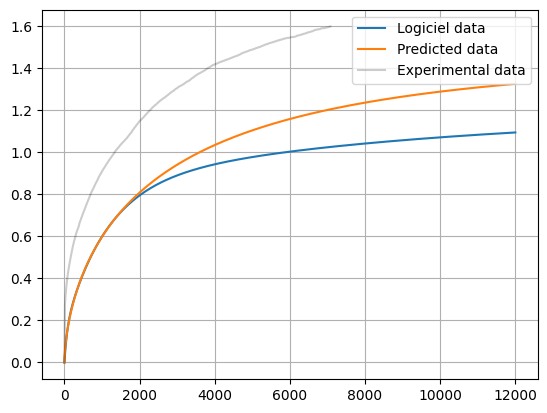

In [113]:
t = df2["Time [min]"]
M = df2["TML_sim [%]"]

plt.figure()
plt.plot(t,M,label="Logiciel data")

plt.plot(t, mass_loss_model(t, results_df["D"][0], results_df["Mm"][0], results_df["c1"][0], results_df["c2"][0]),label="Predicted data")
plt.plot(df3["Time [minutes]"],df3["TML [%]"],"black",alpha=0.2,label="Experimental data")
plt.grid()
plt.legend()
plt.show()

Polynomial Regression: Mm = -0.3687 + 0.0713 * T + -0.0005 * T^2


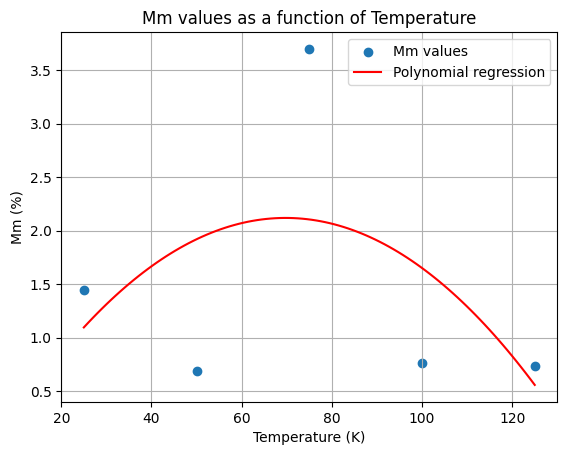

In [105]:
# Extract Mm and T values from the results DataFrame
Mm_values = results_df['Mm'].values
T_values = results_df['Temperature'].values

# Define the new temperature and Mm values
#new_temperature = 223
#new_Mm = 0

# Add the new temperature and Mm values to the existing arrays
#T_values = np.append(T_values, new_temperature)
#Mm_values = np.append(Mm_values, new_Mm)

# Perform linear regression of Mm as a function of T with the updated arrays
slope, intercept, r_value, p_value, std_err = linregress(T_values, Mm_values)

# Check if the correlation coefficient is less than 0.9
if abs(r_value) < Coeff_regression:
    # Perform polynomial regression instead
    degree = 2  # degree of the polynomial regression

    # Fit the polynomial regression
    coeffs = np.polyfit(T_values, Mm_values, degree)
    polynomial = np.poly1d(coeffs)

    # Define the range of temperatures for the regression line
    regression_T_range = np.linspace(np.min(T_values), np.max(T_values), 100)

    # Calculate the regression line values
    regression_Mm_values = polynomial(regression_T_range)

    # Print the equation of the polynomial regression
    equation = f'Polynomial Regression: Mm = {coeffs[2]:.4f} + {coeffs[1]:.4f} * T + {coeffs[0]:.4f} * T^2'
    print(equation)

    # Plot the Mm values and the regression line
    plt.scatter(T_values, Mm_values, label='Mm values')
    plt.plot(regression_T_range, regression_Mm_values, color='red', label='Polynomial regression')
else:
    # Define the range of temperatures for the regression line
    regression_T_range = np.linspace(np.min(T_values), np.max(T_values), 100)

    # Calculate the regression line values
    regression_Mm_values = intercept + slope * regression_T_range

    # Print the equation of the linear regression
    equation = f'Linear Regression: Mm = {intercept:.4f} + {slope:.4f} * T'
    print(equation)

    # Plot the Mm values and the regression line
    plt.scatter(T_values, Mm_values, label='Mm values')
    plt.plot(regression_T_range, regression_Mm_values, color='red', label='Linear regression')

plt.xlabel('Temperature (K)')
plt.ylabel('Mm (%)')
plt.title('Mm values as a function of Temperature')
plt.legend()
plt.grid(True)
plt.show()

Predicted Mm at temperature 25 K (using Polynomial regression): 1.0948263882050329 g


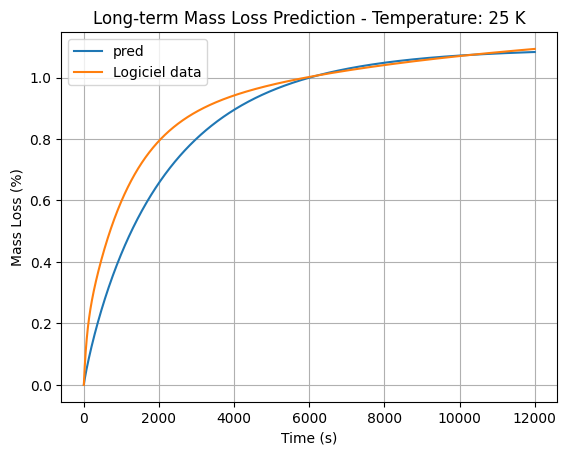

In [112]:
# Define the target temperature for prediction
target_temperature = 25  # Temperature for long-term prediction. Replace with your desired temperature

# Use the equation to predict the value of Mm for the target temperature
if abs(r_value) < Coeff_regression:
    # Perform polynomial regression
    predicted_Mm = polynomial(target_temperature)
    equation_type = 'Polynomial'
else:
    # Perform linear regression
    predicted_Mm = intercept + slope * target_temperature
    equation_type = 'Linear'

print(f'Predicted Mm at temperature {target_temperature} K (using {equation_type} regression): {predicted_Mm} g')

# Calculate D for the prediction temperature
D_pred = np.exp(ln_D0 - Ea / (R * target_temperature))

# Define the time range for prediction
t_pred = np.linspace(0, 12000, 1000)  # Adjust the time range as needed

# Calculate the predicted mass loss using the fitted parameters
M_pred = mass_loss_model(t_pred, D_pred, predicted_Mm, c1, c2) # if needed *1.1 => 10 % more to fit the plateau after long term testing

# Plot the long-term prediction
plt.plot(t_pred, M_pred,label="pred")
plt.xlabel('Time (s)')
plt.ylabel('Mass Loss (%)')
plt.title(f'Long-term Mass Loss Prediction - Temperature: {target_temperature} K')
plt.plot(df2["Time [min]"],df2["TML_sim [%]"],label="Logiciel data")
plt.grid()
plt.legend()
plt.show()
